# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

Haoxue Li (hl3664),  Xiaocheng Li (xl3119),  Diwen Lu (dl3209),  Gaomin Wu (gw1107) by <em>last name</em>

__Contribution:__

1.1 Interpolation (Haoxue Li, Diwen Lu)
<br /> 1.2 Kneser-Ney (Haoxue Li, Diwen Lu)
<br /> 2.1 RNN (Gaomin Wu)
<br /> 2.1 LSTM (Xiaocheng Li)
<br /> 2.1 Performance Evaluation (All, summarized and plotted by Haoxue Li)
<br /> 2.2 Learned Embeddings (Haoxue Li)
<br /> 2.3 Scoring (Diwen Lu)
<br /> 2.4 Sampling (Sampling Function: Gaomin Wu; Analysis: Xiaocheng Li)

In [ ]:
import os
import json
try:
  import jsonlines
except ImportError:
  print('Installing the package, RESTART THIS CELL')
  !pip install jsonlines
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm
import shutil
import numpy as np
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive')

Installing the package, RESTART THIS CELL
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## I. N-Gram Language Modeling

#### Utilities

In [ ]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))    
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [ ]:
datasets, vocab = load_wikitext()

--2019-10-08 17:38:49--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 103.116.4.197
Connecting to nyu.box.com (nyu.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 17:38:49--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-08 17:38:49--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 103.116.4.199
Connecting to nyu.app.box.com (nyu.app.box.com)|103.116.4.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/

### Additive Smoothing

In [ ]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [ ]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [ ]:
# parameter lambda
l=defaultdict(list)
# equal:
l[2]=[1/3,1/3,1/3]
l[3]=[1/4,1/4,1/4,1/4]
l[4]=[1/5,1/5,1/5,1/5,1/5]
# increasing:
l[2]=[1/6,1/3,1/2]
l[3]=[1/10,1/5,3/10,2/5]
l[4]=[1/15,2/15,3/15,4/15,5/15]
# increasing more:
l[2]=[1/111,10/111,100/111]
l[3]=[1/131,10/131,100/131,20/131]
l[4]=[1/132,10/132,100/132,20/132,1/132]
datasets, vocab = load_wikitext()

In [ ]:
class NGramInterpolation(object):
    def __init__(self, n, vsize):
        # n-gram --n
        self.n = n
        # count:{"2":{["<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...}}
        self.count1 = defaultdict(float)
        self.count2 = defaultdict(lambda: defaultdict(float))
        self.total2 = defaultdict(float)
        self.count3 = defaultdict(lambda: defaultdict(float))
        self.total3 = defaultdict(float)
        self.count4 = defaultdict(lambda: defaultdict(float))
        self.total4 = defaultdict(float)
        # vocabulary size+1 --vsize
        self.vsize = vsize

    def estimate(self, sequences):
      for j in range(1,self.n+1):
        # n=2,3,4
        for sequence in sequences:
            padded_sequence = ['<bos>']*(j-1) + sequence + ['<eos>']
            # padded_sequence=[<bos>,i,am,chasing,a,rabbit,<eos>]
            for i in range(len(padded_sequence) - j+1):
              # j=2, i=0
                ngram = tuple(padded_sequence[i:i+j])
                #print(j,ngram)
                #break
                # ngram=[<bos>,i]
                prefix, word = ngram[:-1], ngram[-1]
                # prefix=[<bos>],word=[i]
                # count:{2:{
                            # ["<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...},
                      #  3:{
                            # ["<bos>","<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...},
                # count[2][i][<bos>]+=1
                if j==1:self.count1[word] += 1
                if j==2:self.count2[prefix][word] += 1
                if j==3:self.count3[prefix][word] += 1
                if j==4:self.count4[prefix][word] += 1
                # total:{3:{('<bos>', '<bos>', '<bos>'):5,...},
                      #  4:{('<bos>', '<bos>', '<bos>',"<bos>":100,...}}
                if j==2:self.total2[prefix] += 1
                if j==3:self.total3[prefix] += 1
                if j==4:self.total4[prefix] += 1
        self.k=sum(list(self.count1.values()))
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
      #print(self.count)
      prob=(1/(self.vsize))*l[self.n][0]
      for i in range(1,self.n+1):
        prefix = ngram[-i:-1]
        word = ngram[-1]
        if i==1:
          prob += (l[self.n][i])*self.count1[word]/self.k
        if i==2:
          prob += (l[self.n][i]*self.count2[prefix][word])/ max(self.total2[prefix],1)
        if i==3:
          prob += (l[self.n][i]*self.count3[prefix][word])/ max(self.total3[prefix],1)
        if i==4:
          prob += (l[self.n][i]*self.count4[prefix][word])/ max(self.total4[prefix],1)
      return prob
  

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [ ]:
datasets, vocab = load_wikitext()
for n in [2,3,4]:
    lm1 = NGramInterpolation(n=n, vsize=len(vocab)+1)  # +1 is for <eos>
    lm1.estimate(datasets['train'])

    print("The value of lambda: {}".format(l[n]))
    print("Baseline (Interpolation, n=%d)) Train Perplexity: %.3f" % (n,  perplexity(lm1, datasets['train'])))
    print("Baseline (Interpolation, n=%d)) Valid Perplexity: %.3f" % (n,  perplexity(lm1, datasets['valid'])))

Vocab size: 33175
The value of lambda: [0.009009009009009009, 0.09009009009009009, 0.9009009009009009]
Baseline (Interpolation, n=2)) Train Perplexity: 83.113
Baseline (Interpolation, n=2)) Valid Perplexity: 338.879
The value of lambda: [0.007633587786259542, 0.07633587786259542, 0.7633587786259542, 0.15267175572519084]
Baseline (Interpolation, n=3)) Train Perplexity: 23.235
Baseline (Interpolation, n=3)) Valid Perplexity: 320.460
The value of lambda: [0.007575757575757576, 0.07575757575757576, 0.7575757575757576, 0.15151515151515152, 0.007575757575757576]
Baseline (Interpolation, n=4)) Train Perplexity: 18.167
Baseline (Interpolation, n=4)) Valid Perplexity: 319.789


### I.2 Kenlm

In [ ]:
class NGramkenlm(object):
    def __init__(self, n, vsize):
        self.n = n
        self.count1 = defaultdict(float)
        self.count2 = defaultdict(lambda: defaultdict(float))
        self.total2 = defaultdict(float)
        self.count3 = defaultdict(lambda: defaultdict(float))
        self.total3 = defaultdict(float)
        self.count4 = defaultdict(lambda: defaultdict(float))
        self.total4 = defaultdict(float)
        self.vsize = vsize

    def estimate(self, sequences):
      self.D=[[0 for _ in range(5)] for _ in range(5)]
      for j in range(1,self.n+1):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(j-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - j+1):
                ngram = tuple(padded_sequence[i:i+j])
                prefix, word = ngram[:-1], ngram[-1]
                if j==1:self.count1[word] += 1
                if j==2:self.count2[prefix][word] += 1
                if j==3:self.count3[prefix][word] += 1
                if j==4:self.count4[prefix][word] += 1
                if j==2:self.total2[prefix] += 1
                if j==3:self.total3[prefix] += 1
                if j==4:self.total4[prefix] += 1
        self.k=sum(list(self.count1.values()))
        if j==2:
          n=[]
          for l in range(4):
            n.append(len(self.filterTheDict(self.total2,lambda elem : elem[1]==(l+1))))
          self.D[j][0]=n[0]/(n[0]+2*n[1])
          self.D[j][1],self.D[j][2],self.D[j][3]=1-2*self.D[j][0]*(n[1]/n[0]),2-3*self.D[j][0]*(n[2]/n[1]),3-4*self.D[j][0]*(n[3]/n[2])
        if j==3:
          n=[]
          for l in range(4):
            n.append(len(self.filterTheDict(self.total3,lambda elem : elem[1]==(l+1))))
          self.D[j][0]=n[0]/(n[0]+2*n[1])
          self.D[j][1],self.D[j][2],self.D[j][3]=1-2*self.D[j][0]*(n[1]/n[0]),2-3*self.D[j][0]*(n[2]/n[1]),3-4*self.D[j][0]*(n[3]/n[2])
        if j==4:
          n=[]
          for l in range(4):
            n.append(len(self.filterTheDict(self.total4,lambda elem : elem[1]==(l+1))))
          self.D[j][0]=n[0]/(n[0]+2*n[1])
          self.D[j][1],self.D[j][2],self.D[j][3]=1-2*self.D[j][0]*(n[1]/n[0]),2-3*self.D[j][0]*(n[2]/n[1]),3-4*self.D[j][0]*(n[3]/n[2])
        
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def filterTheDict(self,dictObj, callback):
      newDict = {}
    # Iterate over all the items in dictionary
      for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
          if callback((key, value)):
              newDict[key] = value
      return newDict

    def ngram_prob(self, ngram):
      def update_prob(count,total,i,prob):
          c=count[prefix][word]
          t=total[prefix]
          if c>0:
            alpha=(c-self.D[i][int(c) if c<3 else 3])/max(t,1)
            prob=alpha
          else:
            N1=len(self.filterTheDict(count[prefix],lambda elem : int(elem[1])==1))
            N2=len(self.filterTheDict(count[prefix],lambda elem : int(elem[1])==2))
            N3=len(self.filterTheDict(count[prefix],lambda elem : int(elem[1])>=3))
            sigma=(self.D[i][1]*N1+self.D[i][2]*N2+self.D[i][3]*N3)/max(t,1)
            if sigma>0:
              prob=sigma*prob 
          if prob==0:
            print(c,N1,N2,N3)
          return prob
      for i in range(1,self.n+1):
        prefix = ngram[-i:-1]
        word = ngram[-1]
        if i==1:
          prob = self.count1[word]/self.k
          if self.count1[word]==0:
            prob=1/(self.vsize)
        if i==2:
          prob=update_prob(self.count2,self.total2,i,prob)
        if i==3:
          prob=update_prob(self.count3,self.total3,i,prob)
        if i==4:
          prob=update_prob(self.count4,self.total4,i,prob)
      return prob

#### Results

In [ ]:
datasets, vocab = load_wikitext()
for n in [2,3,4]:
    lm2 = NGramkenlm(n=n, vsize=len(vocab)+1)  # +1 is for <eos>
    lm2.estimate(datasets['train'])

    # print("The value of lambda: {}".format(l[n]))
    print("Baseline (Interpolation, n=%d)) Train Perplexity: %.3f" % (n,  perplexity(lm2, datasets['train'])))
    print("Baseline (Interpolation, n=%d)) Valid Perplexity: %.3f" % (n,  perplexity(lm2, datasets['valid'])))

Vocab size: 33175
Baseline (Interpolation, n=2)) Train Perplexity: 105.160
Baseline (Interpolation, n=2)) Valid Perplexity: 344.829
Baseline (Interpolation, n=3)) Train Perplexity: 18.874
Baseline (Interpolation, n=3)) Valid Perplexity: 345.446
Baseline (Interpolation, n=4)) Train Perplexity: 11.262
Baseline (Interpolation, n=4)) Valid Perplexity: 377.080


## II. Neural Language Modeling with a Recurrent Neural Network

In [ ]:
import torch
import torch.nn as nn
try:
    import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm
from tqdm import tqdm

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [ ]:
# This cell is modified by the version of rnnlm.ipynb
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [ ]:
train_val_dictionary = Dictionary(datasets,include_valid=True)

100%|██████████| 8464/8464 [00:10<00:00, 784.74it/s]


In [ ]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [ ]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

# target is the shifted input sequence

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            # !!!! input: except the last token
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            # !!!! output: start with 2nd token
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [ ]:
wiki_tokenized_datasets = tokenize_dataset(datasets, train_val_dictionary)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][3]

100%|██████████| 9708/9708 [00:00<00:00, 130484.38it/s]


(tensor([[ 0, 75, 26, 76, 77, 33, 78, 10, 79, 80, 20, 81, 82,  5,  6, 83, 84, 85,
           4, 15, 86, 39]]),
 tensor([[75, 26, 76, 77, 33, 78, 10, 79, 80, 20, 81, 82,  5,  6, 83, 84, 85,  4,
          15, 86, 39,  1]]))

In [ ]:
wiki_loaders = {}

batch_size = 32

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [ ]:
#Define the neural network
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence) # RNN naturely produce sequence embedding
        
        # it gives u [ outputs, last hidden layer of the last time step ] !!! Check DOC
        rnn_outputs = self.rnn(embeddings)
 
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [ ]:
# Specify hyper parameter and model
import torch
import torch.nn as nn
import torch.optim as optim

# creating a model, criterion and optimizer

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    hidden_size = 128 # output of RNN is hidden_size
    embedding_dim = 64
    rnn_dropout = 0.1
    num_layers =  2
    

    options = {
        'num_embeddings': len(train_val_dictionary),
        'embedding_dim': embedding_dim,
        'padding_idx': train_val_dictionary.get_id('<pad>'),
        'input_size': embedding_dim,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = RNNLanguageModel(options).to(current_device)
    
# reduction = 'mean': the sum of the output will be divided by the number of elements in the output, 'sum': the output will be summed
criterion = nn.CrossEntropyLoss(ignore_index=train_val_dictionary.get_id('<pad>'), reduction='sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)


In [ ]:
# import early stopping
# reference:https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:# if validation loss increase
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
# initialize the early_stopping object
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)
file_name = 'wiki_rnn_lm_EarlyStop_adam_pati{}_1002.pt'.format(patience)

In [ ]:
plot_cache = []

for epoch_number in range(100):
    avg_loss = -1
    if not load_pretrained:
        # do train
        model.train()
    
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            # on each sample ! zero it
            optimizer.zero_grad()
            # put it to GPU
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            # flat the logit? Now in batch size?

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(train_val_dictionary.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            

            loss /= non_pad_tokens  # very important to normalize your current loss before you run .backward()
            
            # gradient
            loss.backward()
            optimizer.step()
            
            
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    # make sure that your drop put is not used, for example
    model.eval() 
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()
             ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(train_val_dictionary.get_id('<pad>')).sum().item()
            
            valid_non_pad_tokens_cache += non_pad_tokens

        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    plot_cache.append((avg_loss, avg_val_loss))

In [ ]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# save the checkpoint of the best model
torch.save({
    'options': options,
    'loss_cache': plot_cache, # to print the loss curve
    'model_dict': model.state_dict() # the parameter of the model
}, './'+file_name)    

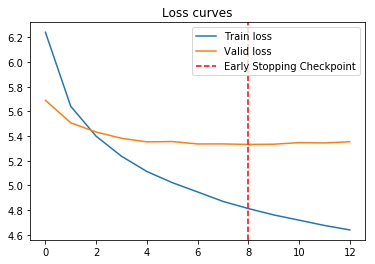

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')
# find position of lowest validation loss
valid_loss = [i[1] for i in plot_cache]
minposs = valid_loss.index(min(valid_loss))
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.legend()
plt.title('Loss curves')
plt.show()

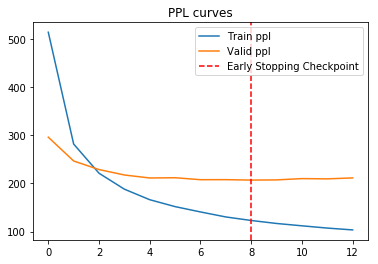

In [ ]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')
# find position of lowest validation loss
valid_loss = [i[1] for i in plot_cache]
minposs = valid_loss.index(min(valid_loss))
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.legend()
plt.title('PPL curves')
plt.show()

#### RNN Baseline

In [ ]:
print('val loss:',min(valid_loss))
print('val ppl:',2**(min(valid_loss)/numpy.log(2)))

val loss: 5.332501461822781
val ppl: 206.95501727964103


In [ ]:
# move checkpoint to google drive
shutil.copy('./'+file_name, './drive/My Drive/'+file_name)

'./drive/My Drive/wiki_rnn_lm_EarlyStop_adam_pati5_1002.pt'

### II.1 LSTM and Hyper-Parameters




#### Hyper-parameters:

embedding_size = 256
    
num_layers = 3

**Dropout Rate:`[0.05, 0.1, 0.2, 0.3]`**

**hidden_size:`[64, 128, 256, 512]`**

In [ ]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, LSTM, and projection layer into a single model.
    """
    
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'],
                                   embedding_dim=options['embedding_dim'], 
                                   padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], 
                            options['hidden_size'], 
                            options['num_layers'], 
                            dropout=options['rnn_dropout'], 
                            batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], 
                                    options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)

        logits = self.projection(lstm_outputs[0]) ## This returns the output of LSTM, instead of the cell.
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# creating a model, criterion and optimizer

load_pretrained = False

num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_lstm_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_lstm_lm.pt')
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512 # output of RNN is hidden_size
    num_layers = 3
    rnn_dropout = 0.4

    options = {
        'num_embeddings': len(train_val_dictionary),
        'embedding_dim': embedding_size,
        'padding_idx': train_val_dictionary.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=train_val_dictionary.get_id('<pad>'), reduction='sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [ ]:
# initialize the early_stopping object
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)
file_name = 'wiki_LSTM_e{}_dp{}.pt'.format(embedding_size, rnn_dropout)

In [ ]:
plot_cache = []

for epoch_number in range(100):
    avg_loss = -1
    if not load_pretrained:
        # do train
        model.train()
    
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            # on each sample ! zero it
            optimizer.zero_grad()
            # put it to GPU
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            # flat the logit? Now in batch size?

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(train_val_dictionary.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            

            loss /= non_pad_tokens  # very important to normalize your current loss before you run .backward()
            
            # gradient
            loss.backward()
            optimizer.step()
            
            
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    # make sure that your drop put is not used, for example
    model.eval() 
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()
             ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(train_val_dictionary.get_id('<pad>')).sum().item()
            
            valid_non_pad_tokens_cache += non_pad_tokens

        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    plot_cache.append((avg_loss, avg_val_loss))

#### Results (LSTM vs. Baseline)

RNN Baseline:     
val ppl: **206.96** 

LSTM:    
val ppl: **172.52**


#### Performance Variation Based on Hyperparameter Values

In [ ]:
valid_loss,perplexity_loss=[[] for _ in range(4)],[[] for _ in range(4)]
hidden_choice=["64","128","256","512"]
dp=["0.05","0.1","0.2","0.3"]
for i in range(4):
  for j in range(4):
    file_name = 'wiki_LSTM_hidden{}_dp{}.pt'.format(hidden_choice[j], rnn_dp[i])
    checkpoint = torch.load(filename)
    loss=checkpoint['loss_cache']
    tvalid_loss=10000
    for k in range(len(loss)):
      tvalid_loss=min(loss[k][1],tvalid_loss)
    valid_loss[i].append(tvalid_loss)
    perplexity_loss[i].append(2**((tvalid_loss)/numpy.log(2)))

In [1]:
perplexity_loss=[[209.08,198.13,200.27,212.77],[196.69,192.99,194.98,196.03],[187.08,182.9,174.9,187.4],[182.44,180.64,179.93,172.52]]

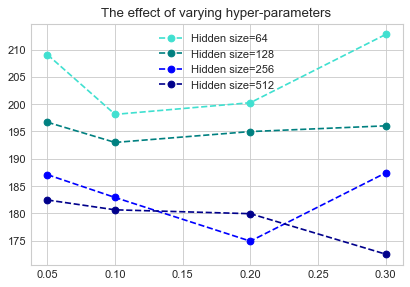

In [2]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
!pip install mpld3
import mpld3
mpld3.enable_notebook()
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 80

ax = numpy.array([0.05,0.1,0.2,0.3])
plt.plot(ax, perplexity_loss[0], label='Hidden size=64',marker='o',linestyle='--',color="turquoise")
plt.plot(ax, perplexity_loss[1], label='Hidden size=128',marker='o',linestyle='--',color="teal")
plt.plot(ax, perplexity_loss[2], label='Hidden size=256',marker='o',linestyle='--',color="blue")
plt.plot(ax, perplexity_loss[3], label='Hidden size=512',marker='o',linestyle='--',color="darkblue")
#plt.axvline(ax[0],ymin=,ymax=, linestyle='--', color='r')
#plt.axvline(ax[1],ymin=,ymax=, linestyle='--', color='r')
#plt.axvline(ax[2],ymin=,ymax=, linestyle='--', color='r')
#plt.axvline(ax[3],ymin=,ymax=, linestyle='--', color='r')

plt.legend()
plt.title('The effect of varying hyper-parameters')
plt.show()

Include a brief (1-2 sentence) discussion of the results:

We achieve the best validation loss in LSTM with **hidden size 512 and dropout rate 0.3**
. From the plot above, we can see that the larger the hiddedn size, the better validation loss. The relationship between dropout rate and validation loss is "U" shape (noted that in dropout rate 0.4, LSTM with hiddedn size 512 achieve worse than 0.3 dropout rate) 

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [ ]:
# load the trained embedding:
checkpoint = torch.load("./drive/My Drive/wiki_LSTM_emb256_dp0.3.pt")
model.load_state_dict(checkpoint['model_dict'])
count=0
for k in model.parameters():
  if count==0:
    LSTM_embedding = k
  elif count==13:
    Projection=k
  count+=1
# Choose a set of 5 words: {"the","run","dog","where","quick"}
words_chosen=["the","run","dog","where","quick"]

In [ ]:
def find_similar(Embeddings,words_chosen):
    words_chosen_id=[train_val_dictionary.get_id(i) for i in words_chosen]
    count=0
    words=words_chosen.copy()
    words_id=words_chosen_id.copy()
    for i in tqdm(words_chosen_id):
      output = [[] for _ in range(len(Embeddings))]
      for j in range(len(Embeddings)):
        t1,t2=Embeddings[i],Embeddings[j]
        k=torch.nn.functional.cosine_similarity(t1.view(1,len(t1)),t2.view(1,len(t2)))
        output[j]+=[j,k]
      output_cloest=sorted(output,key=lambda x: x[1],reverse=True)[1:11]
      output_furthest=sorted(output,key=lambda x: x[1],reverse=False)[1:11]
      word_cloest=[train_val_dictionary.get_token(x[0]) for x in output_cloest]      
      word_furthest=[train_val_dictionary.get_token(x[0]) for x in output_furthest]
      print("\n10 most closet words of "+words_chosen[count]+" is:")
      print(", ".join(word_cloest))
      print("10 most furthest words of "+words_chosen[count]+" is:")
      print(", ".join(word_furthest))
      words+=word_cloest+word_furthest
      words_id+=output_cloest+output_furthest
      count+=1
    return words,words_id


##### Results

In [ ]:
words_chosen=["the","run","dog","where","quick"]
for i in range(len(words_chosen)):
  print("\nFor {}:".format(words_chosen[i]))
  print("Embedding: 10 most closest words for '{}' is ".format(words_chosen[i]))
  print(words[(i*20+5):(i*20+15)])
  print("Projection: 10 most closest words for '{}' is ".format(words_chosen[i]))
  print(words2[(i*20+5):(i*20+15)])
  print("Embedding: 10 most furthest words for '{}' is ".format(words_chosen[i]))
  print(words[(i*20+15):(i*20+25)])
  print("Projection: 10 most furthest words for '{}' is ".format(words_chosen[i]))
  print(words2[(i*20+15):(i*20+25)])


For the:
Embedding: 10 most cloest words for the is 
['independent', 'remedial', 'Shop', 'his', 'Volume', 'Prue', 'Hakim', 'vine', 'main', 'Abbot']
Projection: 10 most cloest words for the is 
['a', 'an', 'his', 'their', 'her', 'this', 'its', 'it', 'both', 'The']
Embedding: 10 most furthest words for the is 
['Influence', 'superiority', 'vertebrae', 'motives', '571', 'MacKay', 'creature', 'Peckhams', 'conducts', 'subjected']
Projection: 10 most furthest words for the is 
['couple', 'essay', 'outbreak', 'benefice', 'catastrophe', 'asymptotic', 'angle', 'berm', 'doorway', 'Pizhi']

For run:
Embedding: 10 most cloest words for run is 
['29', 'Recently', 'striker', 'wickets', '1981', 'flick', 'ruled', 'adulatory', 'GPa', 'canceled']
Projection: 10 most cloest words for run is 
['pass', 'shoot', 'strike', 'act', 'deal', 'defeat', 'transfer', 'move', 'kick', 'win']
Embedding: 10 most furthest words for run is 
['Darryl', 'Dick', 'deserve', 'Millais', 'Tabernacle', '270', 'Weaver', 'Bohemond

#### II.2.2 Embedding Layer

In [ ]:
words,words_id=find_similar(LSTM_embedding,words_chosen)

 20%|██        | 1/5 [00:46<03:05, 46.45s/it]


10 most closet words of the is:
independent, remedial, Shop, his, Volume, Prue, Hakim, vine, main, Abbot
10 most furthest words of the is:
Influence, superiority, vertebrae, motives, 571, MacKay, creature, Peckhams, conducts, subjected


 40%|████      | 2/5 [01:33<02:19, 46.64s/it]


10 most closet words of run is:
29, Recently, striker, wickets, 1981, flick, ruled, adulatory, GPa, canceled
10 most furthest words of run is:
Darryl, Dick, deserve, Millais, Tabernacle, 270, Weaver, Bohemond, Lynx, Schwimmer


 60%|██████    | 3/5 [02:20<01:33, 46.71s/it]


10 most closet words of dog is:
messages, Palestine, reminiscent, Genoa, Nesbitt, crowns, Tabernacle, Mysore, Antarctica, squeezed
10 most furthest words of dog is:
Reala, Carlos, corrected, Mann, PAVN, slam, Clearing, contractors, leave, computational


 80%|████████  | 4/5 [03:07<00:46, 46.79s/it]


10 most closet words of where is:
imply, whom, beyond, earliest, Churches, whether, warn, treating, archaic, beside
10 most furthest words of where is:
clothesline, <, Moreover, coefficient, Sawtooth, 1275, successive, attach, enlargement, Pagoda


100%|██████████| 5/5 [03:55<00:00, 47.15s/it]


10 most closet words of quick is:
miniature, Charleston, separating, Regarding, Live, fulfil, Emanuel, ceremonial, signaling, 1809
10 most furthest words of quick is:
ceilings, calculators, agrees, maturity, Chaytor, exceedingly, swarm, Trương, Knox, ecoregion


In [ ]:
import pickle
#with open("./drive/My Drive/words.txt", "wb") as fp:   #Pickling
 # pickle.dump(words, fp)
#with open("./drive/My Drive/words_id.txt", "wb") as fp:   #Pickling
 # pickle.dump(words_id, fp)
with open("./drive/My Drive/words.txt", "rb") as fp:   # Unpickling
  words = pickle.load(fp)
with open("./drive/My Drive/words_id.txt", "rb") as fp:   # Unpickling
  words_id = pickle.load(fp)

In [ ]:
%pylab inline 
try:
  import umap
except ImportError:
  print('Installing the package, RESTART THIS CELL')
  !pip install umap-learn
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(8,8))
    plt.style.use("ggplot")
    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1],color="navy")
    color=["teal","blue","green","indigo","black"]
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        if (i>=5 and i<=24) or i==0:
          plt.annotate(words[i], (current_point[0], current_point[1]),color=color[0])
        if (i>=25 and i<=44) or i==1:
          plt.annotate(words[i], (current_point[0], current_point[1]),color=color[1])
        if (i>=45 and i<=64) or i==2:
          plt.annotate(words[i], (current_point[0], current_point[1]),color=color[2])
        if (i>=65 and i<=84) or i==3:
          plt.annotate(words[i], (current_point[0], current_point[1]),color=color[3])
        if (i>=85 and i<=104) or i==4:
          plt.annotate(words[i], (current_point[0], current_point[1]),color=color[4])

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
words_id_n=[]
for i in range(len(words_id)):
  if not isinstance(words_id[i],int):
    words_id_n.append(words_id[i][0])
  else:
    words_id_n.append(words_id[i])

##### Results

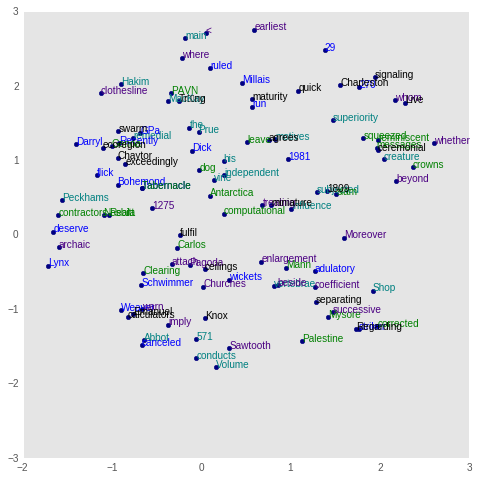

In [ ]:
%matplotlib inline
!pip install mpld3
import mpld3
mpld3.enable_notebook()
umap_plot(LSTM_embedding,words_id_n, words)

<img src="p1.jpeg" alt="Drawing" style="width: 600px;"/>

#### II.2.3 Projection Layer

In [ ]:
# load the projection layer
# Projection_layer = pkl.load(open("", "rb"))
words2,words_id2=find_similar(Projection,words_chosen)
words_id2_n=[]
for i in range(len(words_id2)):
  if not isinstance(words_id2[i],int):
    words_id2_n.append(words_id2[i][0])
  else:
    words_id2_n.append(words_id2[i])

In [ ]:
import pickle
#with open("./drive/My Drive/words.txt", "wb") as fp:   #Pickling
 # pickle.dump(words2, fp)
#with open("./drive/My Drive/words_id.txt", "wb") as fp:   #Pickling
 # pickle.dump(words_id2, fp)
with open("./drive/My Drive/words2.txt", "rb") as fp:   # Unpickling
  words2 = pickle.load(fp)
with open("./drive/My Drive/words_id2.txt", "rb") as fp:   # Unpickling
  words_id2 = pickle.load(fp)

##### Results

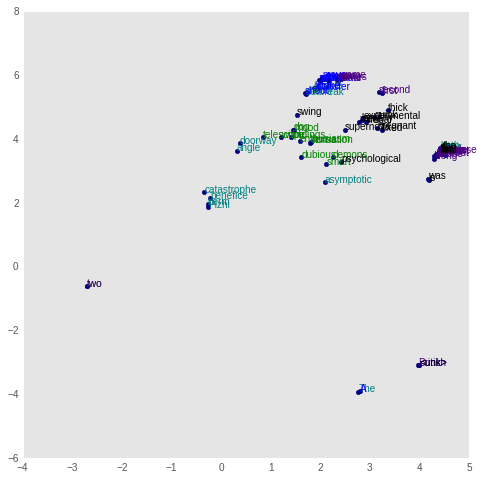

In [ ]:
umap_plot(Projection,words_id2_n, words2)

<img src="p2.jpeg" alt="Drawing" style="width: 600px;"/>

### II.3 Scoring

In [ ]:
# load checkpoint file of the best model and set up the model with the loaded .pt file
if not os.path.exists("./drive/My Drive/wiki_LSTM_emb256_dp0.3.pt"):
    raise EOFError('Need the best trained model!')
model_dict = torch.load("./drive/My Drive/wiki_LSTM_emb256_dp0.3.pt")
options = model_dict['options']

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict['model_dict'])

import spacy
import string
from tqdm import tqdm
from scipy.special import softmax
nlp = spacy.load("en_core_web_sm")

def score(seq_tokenized, model):
    seq_ids = train_val_dictionary.encode_token_seq(seq_tokenized)
    seq_tensored = TensoredDataset([seq_ids])
    seq_loader = DataLoader(seq_tensored, batch_size=1, collate_fn=pad_collate_fn)
    model.eval()
    with torch.no_grad():
        for _, (inp, target) in enumerate(seq_loader):
            inp = inp.to(current_device)
            target = target.to(current_device)

            logits = model(inp)

            target = target.cpu().numpy()[0]
            logits = logits.cpu().numpy()[0]

            probs = [softmax(logit) for logit in logits][0]
            log_prob = 0
            for idx in target:
                log_prob += np.log2(probs[idx])
            log_prob /= len(seq_tokenized)

    return log_prob

#### II.3.2 Highest and Lowest scoring sequences

In [ ]:
# change the batch size of validation data loader to 1, so we feed samples in validation data set one by one
batch_size = 1
validation_data = datasets['valid']

seq_score = [] # a list of tuple, [('<bos> i like apple <eos>', score), ('<bos> i like apple <eos>', score), ... ]

for sample in tqdm(validation_data):
    seq_score.append((' '.join(sample), score(sample, model)))

sorted_seq_score = sorted(seq_score, key=lambda x: x[1], reverse = True)# sort seq_score based on the 2nd value of tuple
print('The 10 sequences from the validation set with the HIGHEST scores are (listed in descending order on score):')
for seq_score_pair in sorted_seq_score[0:10]:
    print('SENTENCE: {}'.format(seq_score_pair[0]))
    print('SCORE: {}\n'.format(seq_score_pair[1]))
print('The 10 sequences from the validation set with the LOWEST scores are (listed in descending order on score):')
for seq_score_pair in sorted_seq_score[-10:]:
    print('SENTENCE: {}'.format(seq_score_pair[0]))
    print('SCORE: {}\n'.format(seq_score_pair[1]))

The 10 sequences from the validation set with the HIGHEST scores are (listed in descending order on score):
SENTENCE: = = = <unk> from the stage = = =
SCORE: -4.891379880905151

SENTENCE: = = = = Invasion of the <unk> = = = =
SCORE: -5.245575467745463

SENTENCE: = = = Army returns = = =
SCORE: -5.362616837024689

SENTENCE: = = = Raid of <unk> = = =
SCORE: -5.428578164842394

SENTENCE: = = = Scientology sources = = =
SCORE: -5.577610671520233

SENTENCE: = = = Hit list = = =
SCORE: -5.598378241062164

SENTENCE: = = = Architectural groups = = =
SCORE: -5.867372214794159

SENTENCE: = = = Training in Europe = = =
SCORE: -6.1901134914822045

SENTENCE: = = <unk> in England and early matches = =
SCORE: -6.231830501556397

SENTENCE: = = Later life and death = =
SCORE: -6.322118163108826

The 10 sequences from the validation set with the LOWEST scores are (listed in descending order on score):
SENTENCE: Initially these were militias in support of British regulars , but when military support for 

#### II.3.3 Modified sequences

##### The sequence I am going to modify is '= = = Army returns = = =', which has score -5.362616837024689.

##### A modified sequence with higher score is '= = = = = = = =', with score -2.716721475124359.
This modified sequence has higher score (higher probability) because after the training, the pattern '= =', '= = =' will be assigned high probability because they appear many times in training data. Therefore, if I change all tokens to be '=', the sequence would have a higher score.

In [ ]:
seq_higher = '= = = = = = = ='
seq_tokenized_higher = [str(token) for token in nlp(seq_higher)]
seq_higher_sc = score(seq_tokenized_higher, model)
print(seq_higher_sc)

-2.716721475124359



##### A modified sequence with lower score is '= = = Army returns on this thing', which has score -7.881718575954437.
This modified sequence has lower score(lower probability) because I decrease the appearance of consecutive '=', which adds more difficulty in predictig '=' given all tokens '=','=','=','Army', 'returns', 'on' before it.

In [ ]:
seq_lower = '= = = Army returns = this thing'
seq_tokenized_lower = [str(token) for token in nlp(seq_lower)]
seq_lower_sc = score(seq_tokenized_lower, model)
print(seq_lower_sc)

-7.881718575954437


### II.4 Sampling

In [ ]:
# load the best model
checkpoint_dict = torch.load('/content/drive/My Drive/wiki_LSTM_emb256_dp0.3.pt')
# read options
option_best = checkpoint_dict['options']
print(option_best)
# initialize model to GPU and read model 
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

model = LSTMLanguageModel(option_best).to(current_device)
model.load_state_dict(checkpoint_dict['model_dict'])

{'num_embeddings': 33181, 'embedding_dim': 256, 'padding_idx': 2, 'input_size': 256, 'hidden_size': 512, 'num_layers': 3, 'rnn_dropout': 0.3}


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F

def get_prob_next_hidden_given_seq(context):
  '''
  context be token to id
  '''
  inp = train_val_dictionary.encode_token_seq(context)
 
  with torch.no_grad():
    model.eval()
    embeddings = model.lookup(context)
    # I don't know how to initialize h0 and how to pass ht
    hidden, cell_stuffs = model.lstm(embeddings)
    logits = model.projection(hidden) ## This returns the output of LSTM, instead of the cell.
    # softmax to get the prob of predicting the last token
    # get the last prediction
    # dim=-1??
    prob_distr = F.softmax(logits[0,-1], dim=-1)
    
  return prob_distr

def lstm_sample():
  context = torch.tensor(train_val_dictionary.get_id('<bos>')).view(1,1).to(current_device)
  xt = context
  while xt != train_val_dictionary.get_id('<eos>'):
    prob = get_prob_next_hidden_given_seq(context)
    xt = torch.multinomial(prob,1)
    context = torch.cat([context, xt.view(1,1)], 1)
  return context

In [ ]:
gen_spls = []
for _ in range(1000):
  sample_list = train_val_dictionary.decode_idx_seq(lstm_sample()[0])
  gen_spls.append(sample_list)
  if _ > 0 and _ % 100 == 99:
    print('{} samples have been generated.'.format(str(_+1)))

100 samples have been generated.
200 samples have been generated.
300 samples have been generated.
400 samples have been generated.
500 samples have been generated.
600 samples have been generated.
700 samples have been generated.
800 samples have been generated.
900 samples have been generated.
1000 samples have been generated.


In [ ]:
for i in range(10):
    print(u'sentence {}:'.format(i+1))
    print(' '.join(gen_spls[i][1:-1]))

sentence 1:
Karamokho financial starlings , such as <unk , expanding an pregnancy of 30 @-@ inch Disc , officer and small submarine music .
sentence 2:
For most of his writings , while his discovery , the colder could be offered to cross in the base below " Nice Urn " or " <
sentence 3:
The water rose from the southeast of St. Louis on 20 September 1992 , which was situated off the downstream of Mogadishu .
sentence 4:
It enabled 50 @,@ 000 @,@ 000 ton to cut salvage .
sentence 5:
But I accept the Women , and I know this show since it was so below , but they tend always to keep it .
sentence 6:
Following the 10th Confederations Cup Finals State Town , the area began to have already been annexed on a Screen time regarding the crusader Bruce and exit grounds to host the series .
sentence 7:
Fowler was unable to break off starting from winning in ten Two games .
sentence 8:
The ﻿ schedule , Tomita Wolf Scott and Dean Smith , among the 130th Masters Film and Rochdale .
sentence 9:
As not a

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [ ]:
import random

def gen_val_spls(val_set, num_spls):
    num_val=len(val_set)
    output_ = []

    val_idx = random.sample(range(0, num_val), num_spls)
    for idx in val_idx:
        output_.append(val_set[idx])
    
    return output_

# Note!!! This step requires to load "datasets" first.
val_spls = gen_val_spls(datasets['valid'], 1000)

In [ ]:
def get_tokens_n_len(gen_, val_, num_spls):
    # get number of unique tokens and sequence lengths
    gen_tokens = []
    val_tokens = []
    gen_len = []
    val_len = []
    assert (len(gen_) == len(val_)),"Lengths of generated and selected val samples do not match!"
    num_spls = len(gen_)

    for i in range(num_spls):
        gen_tokens.extend(gen_[i])
        val_tokens.extend(val_[i])
        # Minus 2 means it subtracts <bos> and <eos>, and it only occurs to generated sentences
        gen_len.append(len(gen_[i])-2)
        val_len.append(len(val_[i]))
    
    gen_tokens = list(set(gen_tokens))
    val_tokens = list(set(val_tokens))

    return len(gen_tokens), len(val_tokens), gen_len, val_len

num_tokens_gen, num_tokens_val, sqn_len_gen, sqn_len_val = get_tokens_n_len(gen_spls, val_spls, 1000)

##### Results

In [ ]:
# Statistics of generated and validation samples
import numpy as np

print('Generated sequences\n\ntoken numbers: {}\nmean of sequence lengths: {}\nvariance of sequence lengths: {}\n'
.format(num_tokens_gen,np.mean(sqn_len_gen),np.var(sqn_len_gen)))
print('Validation sequences\n\ntoken numbers: {}\nmean of sequence lengths: {}\nvariance of sequence lengths: {}\n'
.format(num_tokens_val,np.mean(sqn_len_val),np.var(sqn_len_val)))


Generated sequences

token numbers: 6199
mean of sequence lengths: 24.343
variance of sequence lengths: 133.703351

Validation sequences

token numbers: 5034
mean of sequence lengths: 22.879
variance of sequence lengths: 129.250359



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


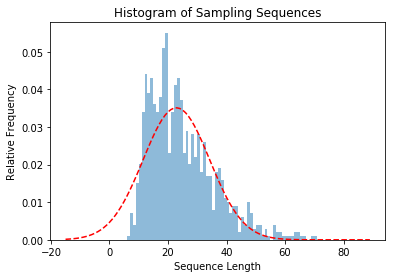

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
bins = np.arange(0, 90, 1)
bins_normal = np.arange(-15, 90, 1)
y = mlab.normpdf(bins_normal, np.mean(sqn_len_val), np.std(sqn_len_val))
plt.hist(sqn_len_gen, bins=bins, density=True, alpha=0.5)
plt.plot(bins_normal, y, 'r--')
plt.title("Histogram of Sampling Sequences")
plt.xlabel('Sequence Length')
plt.ylabel('Relative Frequency')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


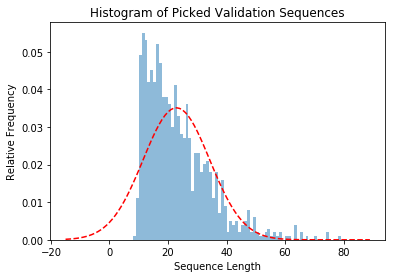

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
bins = np.arange(0, 90, 1)
bins_normal = np.arange(-15, 90, 1)
y = mlab.normpdf(bins_normal, np.mean(sqn_len_val), np.std(sqn_len_val))
plt.hist(sqn_len_val, bins=bins, density=True,alpha=0.5)
plt.plot(bins_normal, y, 'r--')
plt.title("Histogram of Picked Validation Sequences")
plt.xlabel('Sequence Length')
plt.ylabel('Relative Frequency')
plt.show()

#### II.4.4 Example Samples

In [ ]:
selected_sent = []
gen_idx = random.sample(range(0, len(gen_spls)), 3)
for idx in gen_idx:
    selected_sent.append(gen_spls[idx][1:-1])
for sent in selected_sent:
    print(' '.join(sent), '\n')

Hurricane Abby was still disbanded until 1914 , and sold the pole of Ireland 's following year . 

After its release , Liu Kang won their first year at the August 5 , 2003 , the second @-@ seller lyrics , but managed by Zack Zero and Josh Weinstein , she gets a girl character . 

Throughout the time of Sveshnikov Edward Diarmata and his Montgomery , Anderson took " low nothing " that would go through a training until returning to London and suffered aside assistance . 



__Generated Sentences:__

__The First Sentence:__
<br />Hurricane Abby was still disbanded until 1914 , and sold the pole of Ireland 's following year.

__The Second Sentence:__
<br />After its release , Liu Kang won their first year at the August 5 , 2003 , the second @-@ seller lyrics , but managed by Zack Zero and Josh Weinstein , she gets a girl character.

__The Third Sentence:__
<br />Throughout the time of Sveshnikov Edward Diarmata and his Montgomery , Anderson took " low nothing " that would go through a training until returning to London and suffered aside assistance . 

##### Analysis

__It is easy to tell that all these sentences are generated sentences instead of human writing or typing ones,__ as <u>name entities, syntatic structures, and semantic logic are far from correctness.</u> For instance, in the first generated sentence, we can hardly find a __Hurricane Abby__ actually (but still, to give a person's name to a hurricane is the correct habit of meterologists). The logic of "A hurricane is disbanded" and "A hurricane is sold to some place" is also obviously incorrect

__However, the sentences are coherent in staying on one topic.__ It can be easily told that the topic of first sentence is __meterology__, of the second is __entertainment (movie, music, etc.)__ and __one person's story__, and of the third is __literature__.